# Wavenet

In a wavenet we consecutivelly fuse bigrams to incorporate multiple characters into our model. 
1. two chars
2. two bigrams
3. two fourgrams
4. ....



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [19]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])            # 80% split
Xdev, Ydev = build_dataset(words[n1:n2])        # 10% split
Xte, Yte = build_dataset(words[n2:])            # 10% split


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [22]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l
.....hil ---> t
....hilt ---> o
...hilto ---> n
..hilton ---> .
........ ---> j
.......j ---> h
......jh ---> e
.....jhe ---> n
....jhen ---> e
...jhene ---> .


In [69]:
# Torchifying our code :)

# -----------------------------------------------------------------------------------------------------------------------------------
class Linear:
    # Just does a matrix mult in the forward pass
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.50
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# -----------------------------------------------------------------------------------------------------------------------------------


class BatchNorm1d:
    # Normalizes each batch using a running mean and var
    # Basically there is a state in this module which introduces lots of bugs
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropegation)
        self.gamma = torch.ones(dim)    # these are Actual trainable params   
        self.beta = torch.zeros(dim)    # these are Actual trainable params
        # buffers (update the running mean of the total to keep model applicable to single examples instead of batches)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True)   # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * xmean
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
# -----------------------------------------------------------------------------------------------------------------------------------
        
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
# -----------------------------------------------------------------------------------------------------------------------------------
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n , C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------------------------------------------
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # Stretches all parameters to be trained in a list
        return [p for layer in self.layers for p in layer.parameters()]

In [70]:
torch.manual_seed(42);

In [71]:
# initializing the neural net (flatten all the embeddings)

n_embd = 10 # dim of embedding of the character vectors
n_hidden = 68 # the number of neurons in the hidden layer

model = Sequential(
    [
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [74]:
# Parameters for training
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 1e5 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2625
  10000/ 200000: 2.1304
  20000/ 200000: 2.2952
  30000/ 200000: 2.0397
  40000/ 200000: 2.0897
  50000/ 200000: 1.7283
  60000/ 200000: 2.0403
  70000/ 200000: 2.6050
  80000/ 200000: 1.6330
  90000/ 200000: 2.0299
 100000/ 200000: 2.4161
 110000/ 200000: 2.0994
 120000/ 200000: 1.8012
 130000/ 200000: 2.1378
 140000/ 200000: 1.9272
 150000/ 200000: 2.0133
 160000/ 200000: 2.0700
 170000/ 200000: 2.4236
 180000/ 200000: 1.7322
 190000/ 200000: 1.8788


In [81]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (22767, 8, 10)
FlattenConsecutive : (22767, 4, 20)
Linear : (22767, 4, 68)
BatchNorm1d : (22767, 4, 68)
Tanh : (22767, 4, 68)
FlattenConsecutive : (22767, 2, 136)
Linear : (22767, 2, 68)
BatchNorm1d : (22767, 2, 68)
Tanh : (22767, 2, 68)
FlattenConsecutive : (22767, 136)
Linear : (22767, 68)
BatchNorm1d : (22767, 68)
Tanh : (22767, 68)
Linear : (22767, 27)


In [82]:
lossi_avg = torch.Tensor(lossi).view(-1, 1000).mean(1)

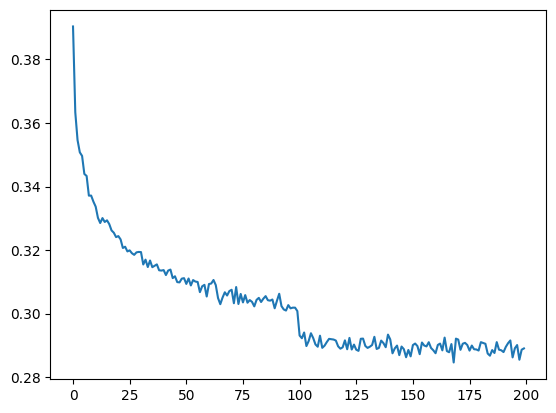

In [83]:
plt.plot(lossi_avg)

In [84]:
lossi_avg.shape

torch.Size([200])

In [85]:
for layer in model.layers:
    layer.training = False

In [86]:
@torch.no_grad()  # A decorator that disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.924547791481018
val 2.027052402496338


In [87]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        
        logits = model(torch.LongTensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

lyncea.
liant.
lantrice.
audlyn.
cadyen.
moustaf.
syfran.
azlyn.
jkeerne.
kiti.
noriandru.
aaitale.
quiallawae.
addalee.
kimaruio.
zacottie.
genesta.
killah.
silvi.
hayes.
